In [1]:
import os
import glob
import re
import pandas as pd
import shutil
import zipfile
import geopandas as gpd
import requests
import json
import numpy as np
import _config

In [2]:
df_projects                     = _config.df_projects
tdm_transit_scenario            = _config.tdm_transit_scenario
input_model_line_files_folder   = _config.input_model_line_files_folder
input_tdm_link_shapefile_folder = _config.input_tdm_link_shapefile_folder
tdm_link_shapefile              = _config.tdm_link_shapefile
tdm_node_shapefile              = _config.tdm_node_shapefile
input_tdm_node_shapefile_folder = _config.input_tdm_node_shapefile_folder
df_centers                      = _config.df_centers
input_taz_shapefile_folder      = _config.input_taz_shapefile_folder
taz_shapefile                   = _config.taz_shapefile

In [3]:
# Get transit line link data for projects

_df_transit_lin_files = pd.read_csv(os.path.join(input_model_line_files_folder, 'files.csv'))
_df_transit_lin_files_lines = pd.read_csv(os.path.join(input_model_line_files_folder, 'lines.csv'))
_df_transit_lin_files_links = pd.read_csv(os.path.join(input_model_line_files_folder, 'links.csv'))

_df_transit_lin_files_lines = pd.merge(_df_transit_lin_files, _df_transit_lin_files_lines, on=['file_index'])
_df_transit_lin_files_lines_links = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_links, on=['file_index','name'])

df_project_transit_links = pd.merge(_df_transit_lin_files_lines_links, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_links = df_project_transit_links[df_project_transit_links['transit_scenario']==tdm_transit_scenario]
df_project_transit_links = df_project_transit_links[['project_id','link_id']]
df_project_transit_links

,project_id,link_id
316,2,25430_25534
317,2,25534_25640
318,2,25640_25685
319,2,25685_25669
320,2,25669_25602
...,...,...
2153,1,15184_15183
2154,1,15183_15182
2155,1,15182_15181
2156,1,15181_15180


In [4]:
_df_transit_lin_files_nodes = pd.read_csv(os.path.join(input_model_line_files_folder, 'nodes.csv'))
_df_transit_lin_files_lines_nodes = pd.merge(_df_transit_lin_files_lines, _df_transit_lin_files_nodes, on=['file_index','name'])

df_project_transit_nodes = pd.merge(_df_transit_lin_files_lines_nodes, df_projects, left_on=['model','name'], right_on=['tdm_model','tdm_line_name'])
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['transit_scenario']==tdm_transit_scenario]
df_project_transit_nodes = df_project_transit_nodes[df_project_transit_nodes['is_stop']==True]
df_project_transit_nodes = df_project_transit_nodes[['project_id','node_id','is_stop']]

df_project_transit_nodes

,project_id,node_id,is_stop
163,2,25602,True
166,2,25351,True
168,2,25215,True
170,2,25077,True
176,2,24858,True
181,2,24726,True
185,2,24568,True
189,2,24467,True
194,2,15086,True
200,2,24279,True


In [5]:
# Read the shapefile
gdf_tdm_link = gpd.read_file(os.path.join(input_tdm_link_shapefile_folder, tdm_link_shapefile))

In [6]:
gdf_tdm_node = gpd.read_file(os.path.join(input_tdm_node_shapefile_folder, tdm_node_shapefile))

In [7]:
gdf_tdm_link.crs

<Projected CRS: EPSG:26912>
Name: NAD83 / UTM zone 12N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 114°W and 108°W - onshore and offshore. Canada - Alberta; Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Arizona; Colorado; Idaho; Montana; New Mexico; Utah; Wyoming.
- bounds: (-114.0, 31.33, -108.0, 84.0)
Coordinate Operation:
- name: UTM zone 12N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

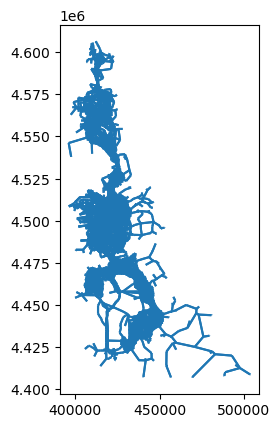

In [8]:
# display the gdf
gdf_tdm_link.plot()

<AxesSubplot:>

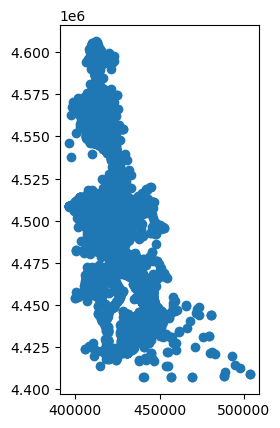

In [9]:
# display the gdf
gdf_tdm_node.plot()

In [10]:
# recalc link id because since it's not populated completely with changes.
gdf_tdm_link['LINKID'] = gdf_tdm_link['A'].astype(str) + '_' + gdf_tdm_link['B'].astype(str)

In [11]:
gdf_tdm_link = gdf_tdm_link[['A','B','LINKID','geometry']]
gdf_tdm_link

,A,B,LINKID,geometry
0,1,29685,1_29685,"LINESTRING (411935.000 4605642.000, 412478.126..."
1,2,29685,2_29685,"LINESTRING (412641.000 4606013.000, 412478.126..."
2,3,29645,3_29645,"LINESTRING (408993.000 4603544.000, 409632.415..."
3,4,29671,4_29671,"LINESTRING (410051.000 4604806.000, 409642.112..."
4,5,29680,5_29680,"LINESTRING (413394.000 4603600.000, 413482.000..."
...,...,...,...,...
57130,95064,95025,95064_95025,"LINESTRING (473181.550 4444171.200, 471782.100..."
57131,95064,95026,95064_95026,"LINESTRING (473181.550 4444171.200, 480751.220..."
57132,95064,95056,95064_95056,"LINESTRING (473181.550 4444171.200, 476015.900..."
57133,95065,3621,95065_3621,"LINESTRING (480730.710 4444037.000, 480767.876..."


In [12]:
df_project_transit_nodes

,project_id,node_id,is_stop
163,2,25602,True
166,2,25351,True
168,2,25215,True
170,2,25077,True
176,2,24858,True
181,2,24726,True
185,2,24568,True
189,2,24467,True
194,2,15086,True
200,2,24279,True


In [13]:
df_project_transit_nodes

,project_id,node_id,is_stop
163,2,25602,True
166,2,25351,True
168,2,25215,True
170,2,25077,True
176,2,24858,True
181,2,24726,True
185,2,24568,True
189,2,24467,True
194,2,15086,True
200,2,24279,True


,A,B,LINKID,geometry,project_id,link_id
0,10036,27491,10036_27491,"LINESTRING (414829.268 4549753.942, 414904.840...",3,10036_27491
1,10046,15180,10046_15180,"LINESTRING (417871.000 4564006.000, 417023.699...",1,10046_15180
2,15069,23429,15069_23429,"LINESTRING (419002.000 4505156.000, 419061.229...",2,15069_23429
3,15069,23429,15069_23429,"LINESTRING (419002.000 4505156.000, 419061.229...",2,15069_23429
4,15086,24384,15086_24384,"LINESTRING (424229.000 4505924.000, 424333.000...",2,15086_24384
...,...,...,...,...,...,...
315,28093,28057,28093_28057,"LINESTRING (411888.713 4560190.725, 411538.000...",3,28093_28057
316,28093,28117,28093_28117,"LINESTRING (411888.713 4560190.725, 412102.000...",3,28093_28117
317,28117,28093,28117_28093,"LINESTRING (412102.000 4560451.000, 411888.713...",3,28117_28093
318,28117,28166,28117_28166,"LINESTRING (412102.000 4560451.000, 412738.974...",3,28117_28166


,N,X,Y,GEOGKEY,EXTERNAL,HOTZN,TAZID,NODENAME,PNR_2015,PNR_2019,...,FARZN23_50,FARE23_32U,FARE23_42U,FARE23_50U,MAG_NODE,WFRC_NODE,geometry,project_id,node_id,is_stop
0,10036,414829.26830,4.549754e+06,414829_4549753,0,0,663,Clearfield,80,80,...,4,4,4,4,0,1,POINT (414829.268 4549753.942),3,10036,True
1,10046,417871.00000,4.564006e+06,417871_4564006,0,0,368,Ogden,80,80,...,2,2,2,2,0,1,POINT (417871.000 4564006.000),1,10046,True
2,15069,419002.00000,4.505156e+06,419002_4505156,0,0,1383,West Valley Central,70,70,...,0,0,0,0,0,1,POINT (419002.000 4505156.000),2,15069,True
3,15086,424229.00000,4.505924e+06,424229_4505924,0,0,1473,Millcreek,70,70,...,0,0,0,0,0,1,POINT (424229.000 4505924.000),2,15086,True
4,15180,417023.69862,4.565620e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (417023.699 4565619.924),1,15180,True
5,15182,414033.26423,4.566399e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (414033.264 4566398.825),1,15182,True
6,15183,412688.63081,4.566366e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (412688.631 4566365.991),1,15183,True
7,15184,411527.01167,4.566354e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (411527.012 4566354.138),1,15184,True
8,15185,410039.42797,4.566378e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (410039.428 4566377.845),1,15185,True
9,15186,408539.99102,4.566402e+06,NaN,0,0,0,NaN,0,0,...,0,0,0,0,0,0,POINT (408539.991 4566401.551),1,15186,True


<AxesSubplot:>

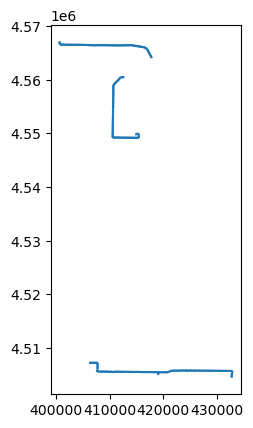

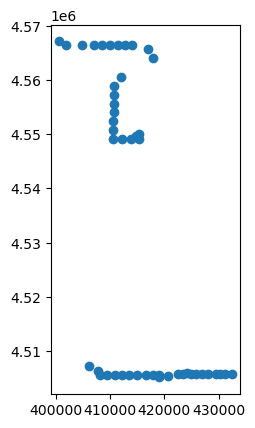

In [14]:
gdf_tdm_link_with_projects = pd.merge(gdf_tdm_link, df_project_transit_links, left_on='LINKID', right_on='link_id')
display(gdf_tdm_link_with_projects)
gdf_tdm_link_with_projects.plot()

gdf_tdm_node_with_projects = pd.merge(gdf_tdm_node, df_project_transit_nodes, left_on='N', right_on='node_id')
display(gdf_tdm_node_with_projects)
gdf_tdm_node_with_projects.plot()

In [15]:
df_centers

Parameter,center_type,FAR,bldg_size,size_of_hh_units,sf_per_employee,units_per_acre,sf_per_acre,%_residential,%_non_res,"gross_to_net_conversion_(streets,_etc)",final_units_per_acre,final_emps_per_acre,application_area,application_area_miles
0,Neighborhood Center,0.6,26136,1000,500,26.136,52.27,0.85,0.15,0.8,18,6,1/8 mile radius,0.125
1,City Center,1.13,49222.8,850,450,57.909176,109.38,0.85,0.15,0.8,39,13,990 foot radius,0.1875
2,Urban Center,1.5,65340,750,400,87.12,163.35,0.85,0.15,0.8,59,20,1/4 mile radius,0.25


In [16]:
#gdf_buffered_projects_by_center_type = gpd.GeoDataFrame()
#
#for index, row in df_centers.iterrows():
#    print(row['center type'])
#
#    # Merging lines based on 'project_id'
#    _gdf_tdm_link_with_projects_merged = gdf_tdm_link_with_projects.dissolve(by='project_id')
#    _gdf_tdm_link_with_projects_merged['center type'] = row['center type']
#
#    # Buffer the merged lines by 'application area miles'
#    # Convert miles to an appropriate unit if your CRS is not in miles
#    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
#    _gdf_tdm_link_with_projects_merged['buffered'] = _gdf_tdm_link_with_projects_merged.geometry.buffer(row['application area miles'] * 1609.34)
#
#    # If you want the buffered geometry as the main geometry
#    _gdf_tdm_link_with_projects_merged.set_geometry('buffered', inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.drop(columns=['geometry','A','B','LINKID','link_id'], inplace=True)
#    _gdf_tdm_link_with_projects_merged.reset_index(inplace=True)
#
#    _gdf_tdm_link_with_projects_merged.plot()
#
#    gdf_buffered_projects_by_center_type = pd.concat([gdf_buffered_projects_by_center_type,_gdf_tdm_link_with_projects_merged])
#
#display(gdf_buffered_projects_by_center_type)

,OBJECTID,AreaName,AreaType,Area,Shape__Area,Shape__Length,geometry
3,28,Canyons,Neighborhood Center,Summit County,4.571034e+05,2580.425872,"POLYGON ((452906.669 4504138.938, 453337.539 4..."
4,35,Crossroads,City Center,Utah County,3.847764e+06,8225.990373,"POLYGON ((421588.154 4469656.985, 421588.155 4..."
5,39,Deer Valley Base,Neighborhood Center,Summit County,1.626199e+05,2318.218626,"POLYGON ((459498.130 4499177.318, 459512.730 4..."
7,43,Downtown Provo,Urban Center,Utah County,1.267076e+07,30147.565078,"POLYGON ((444202.107 4456362.513, 444206.567 4..."
8,46,Downtown Springville,City Center,Utah County,2.891819e+06,13102.452873,"POLYGON ((445119.776 4446055.292, 447868.307 4..."
...,...,...,...,...,...,...,...
296,511,Cottonwood Village,Neighborhood Center,WFRC MPO,1.275807e+05,1603.672031,"POLYGON ((428976.795 4502431.078, 428978.502 4..."
297,512,Independence,City Center,WFRC MPO,5.686543e+06,11136.244285,"POLYGON ((420920.227 4479707.977, 420935.444 4..."
298,513,Porter Rockwell,Urban Center,WFRC MPO,4.110667e+06,10191.341842,"POLYGON ((423145.110 4480905.812, 423142.073 4..."
299,514,Washington Terrace US 89,City Center,WFRC MPO,1.478004e+06,7268.026224,"POLYGON ((418306.763 4557002.282, 418306.874 4..."


<AxesSubplot:>

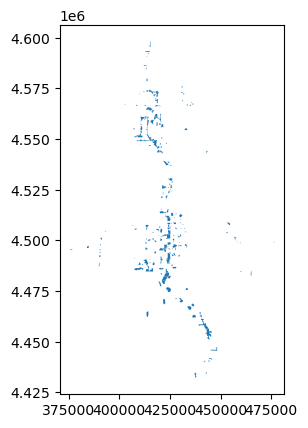

In [17]:
# read in wasatch choice center dataset and convert to UTM Zone 12N
gdf_wc_centers = gpd.read_file('input/wasatch-choice-centers/wc-centers.geojson')
gdf_wc_centers = gdf_wc_centers.to_crs(26912)

# filter for area types 
# Get the unique center types from df_centers
center_types = df_centers['center_type'].unique()

# Filter gdf_wc_centers based on the center types
gdf_filtered_centers = gdf_wc_centers[gdf_wc_centers['AreaType'].isin(center_types)]

display(gdf_filtered_centers)
display(gdf_filtered_centers.plot())

In [18]:
import geopandas as gpd
import pandas as pd
from shapely.ops import nearest_points

conversion_factor = 0.000621371


# Function to find the nearest polygon
def find_nearest_polygon(point_gdf, polygon_gdf):
    temp_df_list = []
    
    for point_idx, point in point_gdf.iterrows():
        polygon_gdf['distance'] = polygon_gdf.geometry.apply(lambda geom: point.geometry.distance(geom))
        nearest_polygon_idx = polygon_gdf['distance'].idxmin()
        distance_in_miles = polygon_gdf.loc[nearest_polygon_idx, 'distance'] * conversion_factor

        temp_df_list.append({
            'point_index': point_idx,
            'polygon_index': nearest_polygon_idx,
            'distance_in_miles': distance_in_miles
        })
    
    return pd.concat([pd.DataFrame([d]) for d in temp_df_list], ignore_index=True)

# Apply the function to find nearest polygons
nearest_polygons_df = find_nearest_polygon(gdf_tdm_node_with_projects, gdf_filtered_centers)

# Join the nearest polygon info back to the original points GeoDataFrame
gdf_nearest_polygons = gdf_tdm_node_with_projects.join(
    nearest_polygons_df.set_index('point_index')['polygon_index'], how='left'
).merge(
    gdf_filtered_centers.rename(columns=lambda x: f'nearest_{x}'),
    left_on='polygon_index', right_index=True, how='left'
).join(
    nearest_polygons_df.set_index('point_index')['distance_in_miles'], how='left'
)

# Inspect the result
#display(gdf_nearest_polygons)

df_nearest_centers = gdf_nearest_polygons.copy()
df_nearest_centers = df_nearest_centers[['project_id','N','nearest_AreaType','distance_in_miles']]

df_nearest_centers['nearest_AreaType_original'] = df_nearest_centers['nearest_AreaType']
# Update 'nearest_AreaType' and 'distance_in_miles' based on the condition
df_nearest_centers.loc[df_nearest_centers['distance_in_miles'] > 1, 'nearest_AreaType'] = 'Neighborhood Center'
df_nearest_centers.loc[df_nearest_centers['distance_in_miles'] > 1, 'distance_in_miles'] = 99999

display(df_nearest_centers)

C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,project_id,N,nearest_AreaType,distance_in_miles,nearest_AreaType_original
0,3,10036,Urban Center,0.005376,Urban Center
1,1,10046,Neighborhood Center,0.485601,Neighborhood Center
2,2,15069,Urban Center,0.000000,Urban Center
3,2,15086,Neighborhood Center,0.000000,Neighborhood Center
4,1,15180,City Center,0.473615,City Center
5,1,15182,City Center,0.281945,City Center
6,1,15183,Neighborhood Center,0.046341,Neighborhood Center
7,1,15184,Neighborhood Center,0.476013,Neighborhood Center
8,1,15185,Neighborhood Center,0.502924,Neighborhood Center
9,1,15186,Neighborhood Center,0.025634,Neighborhood Center


In [19]:
gdf_stops = gdf_tdm_node_with_projects[['N','geometry']]
gdf_stops_with_nearest_center = pd.merge(gdf_stops, df_nearest_centers[['project_id','N','nearest_AreaType']], on='N')
gdf_stops_with_nearest_center

,N,geometry,project_id,nearest_AreaType
0,10036,POINT (414829.268 4549753.942),3,Urban Center
1,10046,POINT (417871.000 4564006.000),1,Neighborhood Center
2,15069,POINT (419002.000 4505156.000),2,Urban Center
3,15086,POINT (424229.000 4505924.000),2,Neighborhood Center
4,15180,POINT (417023.699 4565619.924),1,City Center
5,15182,POINT (414033.264 4566398.825),1,City Center
6,15183,POINT (412688.631 4566365.991),1,Neighborhood Center
7,15184,POINT (411527.012 4566354.138),1,Neighborhood Center
8,15185,POINT (410039.428 4566377.845),1,Neighborhood Center
9,15186,POINT (408539.991 4566401.551),1,Neighborhood Center


C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\bhereth\AppData\Local\Temp\ipykernel_17392\4275307832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _gdf.drop(columns=['geometry'], inplace=True)
C:\Users\bhereth\AppData\Roaming\Python\Python39\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

Neighborhood Center
City Center
Urban Center


,index,N,project_id,nearest_AreaType,buffered
0,1,10046,1,Neighborhood Center,"POLYGON ((418072.167 4564006.000, 418071.199 4..."
1,3,15086,2,Neighborhood Center,"POLYGON ((424430.167 4505924.000, 424429.199 4..."
2,6,15183,1,Neighborhood Center,"POLYGON ((412889.798 4566365.991, 412888.830 4..."
3,7,15184,1,Neighborhood Center,"POLYGON ((411728.179 4566354.138, 411727.210 4..."
4,8,15185,1,Neighborhood Center,"POLYGON ((410240.595 4566377.845, 410239.627 4..."
5,9,15186,1,Neighborhood Center,"POLYGON ((408741.159 4566401.551, 408740.190 4..."
6,10,15187,1,Neighborhood Center,"POLYGON ((407170.602 4566383.771, 407169.633 4..."
7,11,15188,1,Neighborhood Center,"POLYGON ((405019.236 4566454.891, 405018.267 4..."
8,12,15189,1,Neighborhood Center,"POLYGON ((402162.601 4566472.671, 402161.632 4..."
9,13,15191,1,Neighborhood Center,"POLYGON ((400864.670 4567083.113, 400863.701 4..."


<AxesSubplot:>

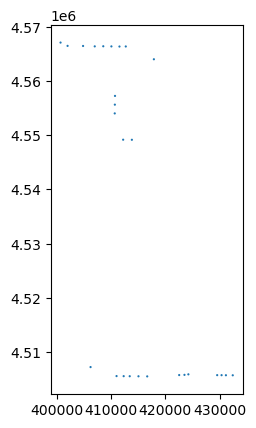

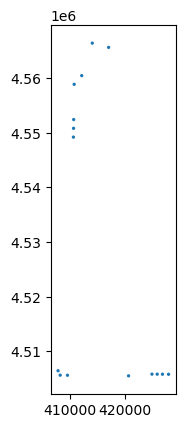

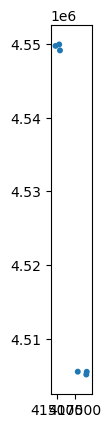

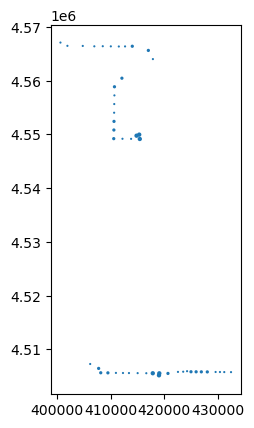

In [20]:
gdf_buffered_stops_with_centers = gpd.GeoDataFrame()

for index, row in df_centers.iterrows():
    print(row['center_type'])

    _gdf = gdf_stops_with_nearest_center[gdf_stops_with_nearest_center['nearest_AreaType']==row['center_type']]

    # Buffer the merged lines by 'application area miles'
    # Convert miles to an appropriate unit if your CRS is not in miles
    # For example, if CRS is in meters, convert miles to meters (1 mile = 1609.34 meters)
    _gdf['buffered'] = _gdf.geometry.buffer(row['application_area_miles'] * 1609.34)

    # If you want the buffered geometry as the main geometry
    _gdf.set_geometry('buffered', inplace=True)

    _gdf.drop(columns=['geometry'], inplace=True)
    _gdf.reset_index(inplace=True)

    _gdf.plot()

    gdf_buffered_stops_with_centers = pd.concat([gdf_buffered_stops_with_centers,_gdf])

display(gdf_buffered_stops_with_centers)

gdf_buffered_stops_with_centers.plot()

<AxesSubplot:>

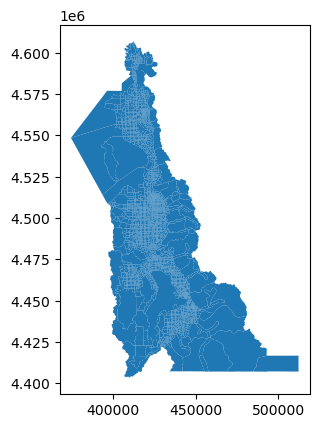

In [21]:
# import taz shapefile
gdf_taz = gpd.read_file(os.path.join(input_taz_shapefile_folder, taz_shapefile))
gdf_taz = gdf_taz.to_crs(26912)
gdf_taz.plot()

,index,N,project_id,nearest_AreaType,TAZID,ACRES,geometry,area_sqm,area_acres
0,1,10046,1,Neighborhood Center,367,116.470509,"POLYGON ((417673.698 4563966.754, 417670.801 4...",27442.266223,6.781132
1,1,10046,1,Neighborhood Center,368,50.056932,"POLYGON ((417794.017 4564191.855, 417812.604 4...",34066.705401,8.418066
2,1,10046,1,Neighborhood Center,369,26.905027,"POLYGON ((418071.199 4563986.282, 418068.302 4...",19934.704560,4.925973
3,1,10046,1,Neighborhood Center,388,350.740952,"POLYGON ((417851.282 4563805.801, 417831.754 4...",20979.132171,5.184056
4,1,10046,1,Neighborhood Center,390,37.583728,"POLYGON ((418063.505 4563947.604, 418056.855 4...",24508.174705,6.056102
...,...,...,...,...,...,...,...,...,...
164,43,27575,3,Urban Center,660,214.511206,"POLYGON ((415723.125 4549909.935, 415717.331 4...",145066.152805,35.846627
165,41,27479,3,Urban Center,702,330.569711,"POLYGON ((415831.398 4549099.564, 415825.604 4...",171252.081197,42.317311
166,41,27479,3,Urban Center,703,271.852095,"POLYGON ((415765.529 4549362.525, 415785.828 4...",799.934731,0.197668
167,41,27479,3,Urban Center,709,165.899429,"POLYGON ((415422.269 4548737.094, 415422.400 4...",34.043252,0.008412


<AxesSubplot:>

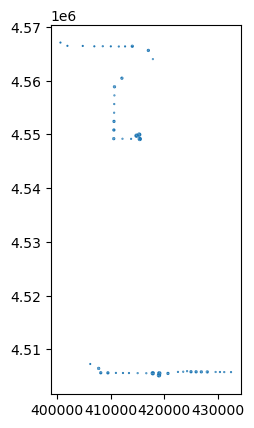

In [22]:
# Assuming gdf1, gdf2, and gdf3 are your GeoDataFrames

# Perform the intersection of the first two GeoDataFrames
gdf_buffered_stops_with_centers_taz = gpd.overlay(gdf_buffered_stops_with_centers, gdf_taz[['TAZID','ACRES','geometry']], how='intersection')


# Calculate the area in square meters
gdf_buffered_stops_with_centers_taz['area_sqm'] = gdf_buffered_stops_with_centers_taz.geometry.area

# Convert the area to acres
gdf_buffered_stops_with_centers_taz['area_acres'] = gdf_buffered_stops_with_centers_taz['area_sqm'] / 4046.85642

# The final_intersection GeoDataFrame now contains the intersection of all three GeoDataFrames
display(gdf_buffered_stops_with_centers_taz)
gdf_buffered_stops_with_centers_taz.plot()


In [23]:
gdf_buffered_stops_with_centers_taz.to_file("intermediate/buffered-stops-with-centers-taz.geojson", format='geojson')
print('Exported')

Exported
